<a href="https://colab.research.google.com/github/asarria48/ML-for-materials/blob/main/BO_Structure_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structure search with Bayesian Optimization

This tutorial demonstrates how to use BO to optimize the atomistic configuration of materials. This can be done by mapping the configurational degrees of freedom to the total energy landscape, and inferring the global minimum of energy. The energy landscapes, refined by iterative data acquisitons, can be employed to visualise low energy configurations (they are chemically interpretable).

<img src="https://gitlab.com/joalof/bigmax_boss_tutorials/-/raw/319e6ba6dbbf37ac456abc6dac7f4de5ef097312/figures/ss_scenarios.png" width="800px"/>

At the outset, the user should consider which **key degrees of freedom** control the energetics of the research problem. In the case of adsorption of organic molecules to the surface, these could be the molecule position or orientation above the surface. The molecular conformation can often be kept fixed. In the case of flexible molecules, we need to conduct a conformer search and minimize the energy with respect to dihedral angles. The degrees of freedom and their bounds define the N-dimensional BO structure search.

BO can proceed on any data source (experiment or computation), any computer code (molecular mechanics or ab initio approaches), on any number of cores (it has an API and command line interface) and can fit a GP surrogate model of any or many materials properties extracted from calculations (energy, band gaps, HOMO/LUMO). Flexible use of external functions is facilitated by the BOSS **user function**, where the user transforms the BO sampling across the defined search domain into an atomistic configuration, the calculation is performed, and the desired value is parsed and returned.

<img src="https://gitlab.com/joalof/bigmax_boss_tutorials/-/raw/319e6ba6dbbf37ac456abc6dac7f4de5ef097312/figures/user_fn.png" width="800px"/>


## Molecular conformer structure search

Let us consider the problem of alanine conformational structure search, as shown in the image above. We identify 4 degrees of freedom, described by dihedral angles `[d1, d2, d3, d4]`. We will use BO to refine a GPR model mapping the state vector of dihedral angles to conformer energy `E`, as computed by an external total energy code. **Our objective is to find the state vector (configuration) that minimizes the total energy.**

We will first consider a 2D conformer search (other variables kept fixed) and analyse the results, then proceed with a 4D conformer search. <br>
To begin, let's load the required python packages.

In [3]:
!pip3 install aalto-boss

In [2]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

from boss.bo.bo_main import BOMain
from boss.pp.pp_main import PPMain

import pylab

pylab.show()

In [6]:
!pip uninstall -y aalto-boss numpy GPy scipy matplotlib
!pip install aalto-boss

Found existing installation: aalto-boss 1.13.1
Uninstalling aalto-boss-1.13.1:
  Successfully uninstalled aalto-boss-1.13.1
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: GPy 1.13.2
Uninstalling GPy-1.13.2:
  Successfully uninstalled GPy-1.13.2
Found existing installation: scipy 1.12.0
Uninstalling scipy-1.12.0:
  Successfully uninstalled scipy-1.12.0
Found existing installation: matplotlib 3.8.4
Uninstalling matplotlib-3.8.4:
  Successfully uninstalled matplotlib-3.8.4
  Using cached aalto_boss-1.13.1-py3-none-any.whl.metadata (3.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.6 MB/s eta 0:00:00
  Using cached GPy-1.13.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB/s eta 0:00:00
  Using cached matplotlib-3.8.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.

In this example, we used the AMBER code and `gaff` force field to compute the total energy for each sampled configuration. To simplify this tutorial, we construted an **AMBER emulator function** to simulate AMBER energies without the code itself. We did this by building a GPR generative model based on AMBER data, then encoding it in an AMBER emulator function.

In [15]:
# Here we load AMBER data from a file and build an GPR model.
def load_model(filename):
    """Recreates a GPR model from saved parameters and data. """

    # load saved data
    data = np.load(filename)
    dim = data["X"].shape[1]

    # create kernel and mean functions
    kernel = GPy.kern.StdPeriodic(input_dim=dim, ARD1=True, ARD2=True)
    mean_func = GPy.mappings.Constant(dim, 1)

    # create model
    model = GPy.models.GPRegression(
        data["X"], data["Y"], kernel=kernel, mean_function=mean_func
    )

    # set model params
    model[:] = data["params"]
    model.fix()
    model.parameters_changed()

    return model

# Here, we define the AMBER emulator for a 2D structure search in d1-d4

#!wget https://gitlab.com/joalof/bigmax_boss_tutorials/-/raw/319e6ba6dbbf37ac456abc6dac7f4de5ef097312/data/model_2D_E0.npz
#AMBER_emulator = load_model("model_2D_E0.npz")

# Here, we define the AMBER emulator for a 4D structure search in d1-d2-d3-d4
!wget https://gitlab.com/joalof/bigmax_boss_tutorials/-/raw/319e6ba6dbbf37ac456abc6dac7f4de5ef097312/data/model_4D_E0.npz
AMBER_emulator = load_model("model_4D_E0.npz")

# Here, we define the utility function that retrieves data from the AMBER emulator.
def f(X):
    return AMBER_emulator.predict(np.atleast_2d(X))[0]

--2025-10-16 21:13:26--  https://gitlab.com/joalof/bigmax_boss_tutorials/-/raw/319e6ba6dbbf37ac456abc6dac7f4de5ef097312/data/model_4D_E0.npz
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8962 (8.8K) [application/octet-stream]
Saving to: ‘model_4D_E0.npz’

model_4D_E0.npz     100%[===================>]   8.75K  --.-KB/s    in 0s      

2025-10-16 21:13:26 (78.7 MB/s) - ‘model_4D_E0.npz’ saved [8962/8962]



## Running BO

Once more, we need to set up the BO run by defining the:

* `bounds` of the search domain: the number of [lower, upper] bound pairs in the vector will tell BOSS that this is a 2D search.
* `yrange` of the expected function
* `kernel`: since all dihedral angles are 360-periodic, we can set the kernel to *standard periodic*
* number of initial points `initpts` and BO iterations `iterpts`

After setting BO, we are ready to run!

In [16]:
# Here, we define the BO run.
#bounds = [[-0.0, 360.0]] * 2   # It can be done like this, or explicitly below
bounds = [[0.0, 360.0], [0.0, 360.0], [0.0, 360.0], [0.0, 360.0]]

bo = BOMain(
    f,
    bounds,
    yrange=[0, 1],
    kernel="stdp",
    initpts=5,
    iterpts=160,
)

# Here we perform BO, it should be a minute or two
res = bo.run()

We immediately run post-processing to check results. We set additional options to:

* `pp_iters`: postprocess only BO steps 0, 10, 20 and 40 for convenience
* `pp_model_slice`: explicitly request a model slice in [dim1, dim2, Npts], which is useful to visualise N-dimensional models

In [18]:
pp = PPMain(res, pp_models=True, pp_iters=[60,80, 120, 160], pp_model_slice=[1,4,50])
pp.run()

## Results and Analysis
We start by checking **data acqusition** plots. Since we have 2 dimensions, the lower plot now features the sampling locations in both dihedrals. Amber energy values are all positive, and a global minimum was clearly idenfitifed. On the right, the **hyperparameter plot** indicates that the model has also converged.


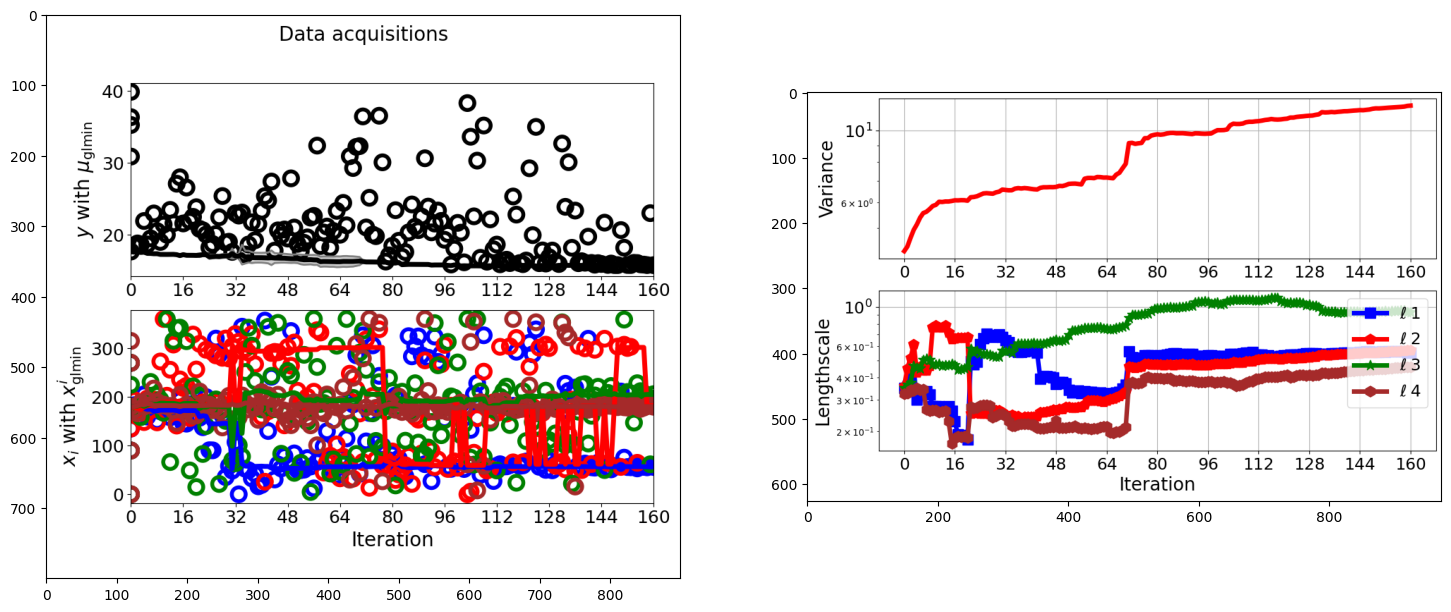

In [21]:
# Let's inspect model data in BOSS

# figure size in inches optional
rcParams['figure.figsize'] = 18, 14

# read images
acq = mpimg.imread('postprocessing/acquisition_locations.png')
param = mpimg.imread('postprocessing/hyperparameters.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(acq)
ax[1].imshow(param)

Let us review the potential energy surface (PES) landscapes simulated by GPR after 10, 20 and 40 BO points. We can see that **the global mininum was found with few datapoints**, but more sampling is needed to converge the energy landscapes.

In [20]:
# Let's inspect the d1-d4 2D model fitting for alanine

# figure size in inches optional
rcParams['figure.figsize'] = 18, 14

# read images
it1 = mpimg.imread('postprocessing/graphs_models/it0010_npts0015.png')
it3 = mpimg.imread('postprocessing/graphs_models/it0020_npts0025.png')
it5 = mpimg.imread('postprocessing/graphs_models/it0040_npts0045.png')

# display images
fig, ax = plt.subplots(1,3)
ax[0].imshow(it1)
ax[1].imshow(it3)
ax[2].imshow(it5)

FileNotFoundError: [Errno 2] No such file or directory: 'postprocessing/graphs_models/it0010_npts0015.png'

# Exercise:
Re-do the conformer search with **all 4 degrees of freedom** by uncommenting code above. Note that you have to load the 4D dataset for the AMBER emulator function, and adjust the bounds for 4 dimensions instead of 2. You can execute the BO run with the same settings. In 4D, BO should take a couple of min.

Re-plot all the graphs above. In a 4D structure search, domain volume to cover by sampling is much bigger than in 2D, so the same amount of sampling results in poorer models.

* How does the convergence look for the global minimum prediction and the model hyperparameters?
* What about the energy landscapes?

When post-processing, you can now choose to slice the 4D surrogate model in the plane of any dihedral pair with the `pp_model_slice` keyword. The cross-section is always extracted in the plane of the global minimum solution (you can choose other planes via keywords). Once the BO run is complete, you can rerun the post-processing in different ways, but note that the `postprocessing` directory will be overwritten unless you rename it.

* Dihedral variable d7 has a 120deg symmetry which can be accounted for with a shorter domain boundary - is this visible in the energy landscapes?
* The 2D model was produced for d1-d4 pair, which dominates conformer energetics. If you slice the 4D model in the d1-d4 plane, does it look similar?